### 11장 레이블되지 않은 데이터 다루기: 군집 분석
- 11.1 k-평균 알고리즘을 사용하여 유사한 객체 그룹핑
- 11.2 계층적인 트리로 클러스터 조직화
- 11.3 DBSCAN을 사용하여 밀집도가 높은 지역 찾기
--- 

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [6]:
## 연습용 2차원 데이터셋 생성 
from sklearn.datasets import make_blobs 
X, y = make_blobs(n_samples = 150, 
                  n_features = 2,
                  centers = 3, 
                  cluster_std = 0.5, 
                  shuffle = True, random_state = 42
                  )

print(X.shape)
print(y.shape)

(150, 2)
(150,)


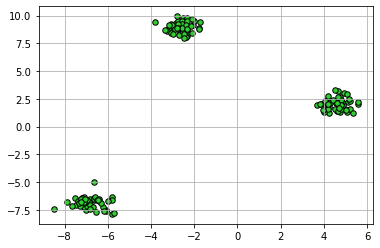

In [14]:
plt.scatter(X[:, 0], X[:, 1], c='limegreen', edgecolor = 'black', marker = 'o', s=30) # s: market size 
plt.grid()
plt.show()

--- 
#### 1. K-means 실행 
- k갯수를 지정해 줘야 하는 것은 한계 
- 초기 클러스터 센트로이드를 최대한 서로 멀리 떨어지도록 잡아준다. (init = 'k-means++') 
---

In [18]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters = 3, random_state= 42)

km.fit(X)

KMeans(n_clusters=3, random_state=42)

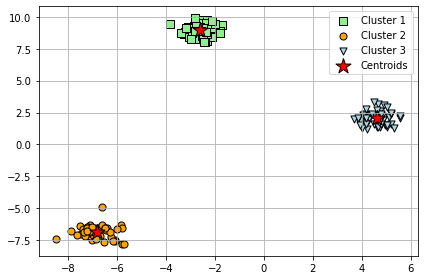

In [21]:
y_km = km.fit_predict(X)
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')

plt.scatter(km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 1],
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')

plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
# plt.savefig('images/11_02.png', dpi=300)
plt.show()

- kmeans 알고리즘에 의해, 각 군집의 중앙에 센트로이드가 잘 위치되었음을 확인 

---
#### 2. elbow 차트를 사용한 최적 k 찾기 
---

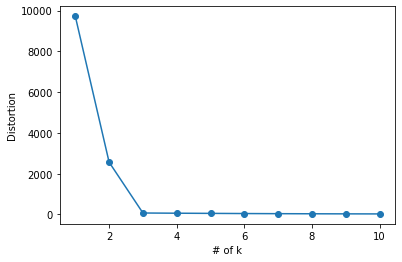

In [23]:
distortions = []
for i in range(1, 11): 
    km = KMeans(n_clusters = i, random_state = 42)
    km.fit(X)
    distortions.append(km.inertia_)  ## km.inertia_에는 훈련후 SSE가 저장되어 있다. 
    
plt.plot(range(1,11), distortions, marker = 'o')
plt.xlabel('# of k')
plt.ylabel('Distortion')
plt.show()

---
#### 3. 실루엣 분석 (silhouette analysis) 
- 클러스터내 샘플들이 조밀하게 모여있는 정도를 나타냄(응집도와 분리도). 
- +/- 1 사이의 값 (1에 가까울수록 잘 분리됨) 
---

In [24]:
from matplotlib import cm
from sklearn.metrics import silhouette_samples

## k=2인 경우 
km = KMeans(n_clusters = 2, random_state = 42)
y_km = km.fit_predict(X)

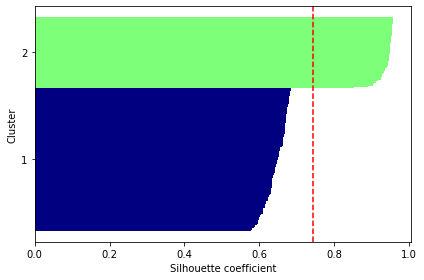

In [25]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('images/11_04.png', dpi=300)
plt.show()

In [27]:
## k=3인 경우 
km = KMeans(n_clusters = 3, random_state = 42)
y_km = km.fit_predict(X)

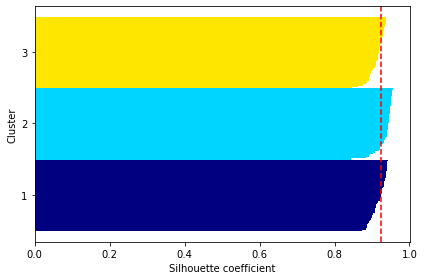

In [28]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('images/11_04.png', dpi=300)
plt.show()

---
#### 4. 계층군집(hierarchical clustering) 
- 트리형태의 의미있는 분류체계를 만들어 주기 때문에 이해하기 좋다. 
- 클러스터 갯수 k를 미리 지정하지 않아도 된다. 
- 처음에 각 샘플들을 독립적인 클러스터로 간주하고, 거리가 가장 가까운 것부터 합쳐나가는 방식으로 군집화 한다. 
---

In [29]:
## sklearn의 AgglomerativeClustering 클래스 사용 
from sklearn.cluster import AgglomerativeClustering 
ac = AgglomerativeClustering(n_clusters = 3, 
                             affinity = 'euclidean', 
                             linkage = 'complete') 
labels = ac.fit_predict(X)
print('Clustered labels =', labels)

Clustered labels = [2 2 0 1 0 1 2 2 0 1 0 0 1 0 1 2 0 2 1 1 2 0 1 0 1 0 0 2 0 1 1 2 0 0 1 1 0
 0 1 2 2 0 2 2 1 2 2 1 2 0 2 1 1 2 2 0 2 1 0 2 0 0 0 1 1 1 1 0 1 1 0 2 1 2
 2 2 1 1 1 2 2 0 2 0 1 2 2 1 0 2 0 2 2 0 0 1 0 0 2 1 1 1 2 2 1 2 0 1 2 0 0
 2 1 0 0 1 0 1 0 2 0 0 1 0 2 0 0 1 1 0 2 2 1 1 2 1 0 1 1 0 2 2 0 1 2 2 0 2
 2 1]


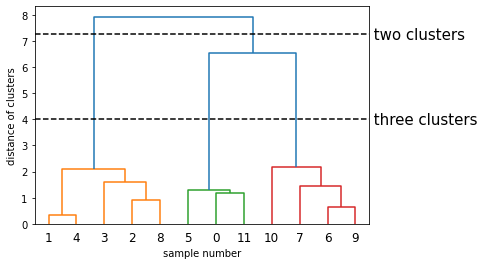

In [34]:
from scipy.cluster.hierarchy import dendrogram, ward
x, y = make_blobs(random_state=0, n_samples=12)

### 데이터 배열 x에 ward 함수를 적용, scipy의 ward 함수는 병합 군집을 수행할 때 생성된 거리 정보가 담긴 배열을 반환
linkage_array = ward(x)
dendrogram(linkage_array)
ax = plt.gca() # get current axes
bounds = ax.get_xbound() # x축 데이터(처음과 끝), 즉 최소/최대값을 가진 (1,2)리스트
ax.plot(bounds, [7.25, 7.25], linestyle='--', c='k') # 임의로 라인 생성
ax.plot(bounds, [4, 4], linestyle='--', c='k')
ax.text(bounds[1], 7.25, ' two clusters', va='center', fontdict={'size':15}) # bounds: x축 끝
ax.text(bounds[1], 4, ' three clusters', va='center', fontdict={'size':15})
plt.xlabel('sample number')
plt.ylabel('distance of clusters')
plt.show()

---
#### 5. DBscan 
- 특정반경 안에 있는 샘플갯수, 즉 밀집도 기반으로 군집화 실행 
- K-means와 달리 원형 클러스터를 가정하지 않음 
---

(200, 2)
(200,)


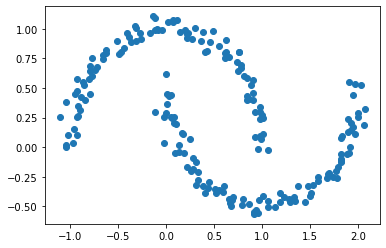

In [36]:
## 비선형 - 반달모양 분포 데이터셋 생성 
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 200, noise = 0.05, random_state = 42)
print(X.shape)
print(y.shape)

plt.scatter(X[:, 0], X[:,1])
plt.show()

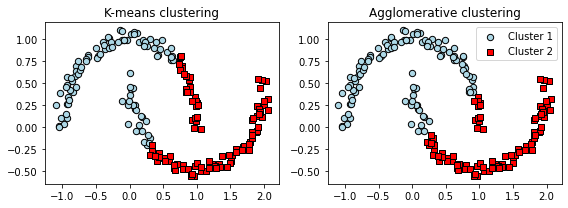

In [37]:
## k-means와 Agglomertive clustering 시도 --> 군집화 불가 예상 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, n_init=10, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2,
                             metric='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
# plt.savefig('images/11_15.png', dpi=300)
plt.show()

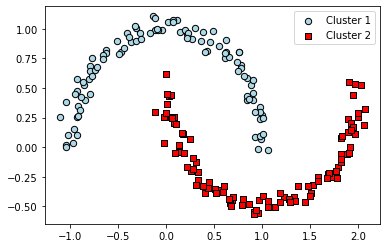

In [39]:
## DBscan 시도 
from sklearn.cluster import DBSCAN 
db = DBSCAN(eps = 0.2, min_samples = 5, metric = 'euclidean')
y_db = db.fit_predict(X)

plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='Cluster 2')
plt.legend()
plt.show()